In [10]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,sklearn,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.5.6
IPython 7.7.0

numpy 1.15.2
sklearn 0.20.0
tensorflow 1.14.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-64-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [12]:
sound_names = ["amino acid sample", "amino acid standard", "else"]
sound_data = np.load('urban_sound.npz')
X_data = sound_data['X']
y_data = sound_data['y']
groups = sound_data['groups']
X_data.shape, y_data.shape, groups.shape

((12, 193), (12, 3), (12, 1))

In [13]:
train, test = train_test_split(X_data, test_size=0.2)
train, val = train_test_split(y_data, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

9 훈련 샘플
3 검증 샘플
3 테스트 샘플


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in gss.split(X_data, y_data, groups=groups):
    X_train = X_data[train_idx]
    y_train = y_data[train_idx]
    groups_train = groups[train_idx]

    X_val = X_data[val_idx]
    y_val = y_data[val_idx]
    groups_test = groups[val_idx]

len(X_train), len(X_val), len(y_train), len(y_val)

(0, 12, 0, 12)

In [16]:
X_train.shape, y_train.shape

((0, 193), (0, 3))

In [17]:
np.intersect1d(groups_train, groups_test)

array([], dtype=float64)

In [18]:
training_epochs = 100
n_dim = 193
n_classes = 3
learning_rate = 0.01

In [19]:
g1 = tf.Graph()
with g1.as_default():
    X = tf.placeholder(tf.float32, [None, n_dim])
    Y = tf.placeholder(tf.float32, [None, n_classes])

    c1 = tf.layers.conv2d(tf.reshape(X, [-1, 1, n_dim, 1]), 50, (1, 5), padding='same', 
                          activation=tf.nn.sigmoid, name="c1")
    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size=[1, 2], strides=2)
    c2 = tf.layers.conv2d(tf.reshape(p1, [-1, 1, 96, 50]), 100, (1, 5), padding='same', 
                          activation=tf.nn.sigmoid, name="c2")
    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size=[1, 2], strides=2)

    h_p = tf.reshape(p2, [-1, 48*100])

    h_1 = tf.layers.dense(inputs=h_p, units=4800, activation=tf.nn.sigmoid,
                          kernel_initializer=tf.contrib.layers.xavier_initializer(), name="fc1")

    y_hat = tf.layers.dense(inputs=h_1, units=n_classes,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                            name="h4")

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_hat))

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.


Validation accuracy:  0.0
Last cost:  nan


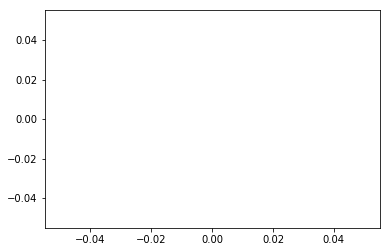

In [21]:
cost_history = []
with tf.Session(graph=g1) as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        _, cost = sess.run([optimizer, loss], feed_dict={X: X_train, Y: y_train})
        cost_history.append(cost)
    
    print('Validation accuracy: ', round(sess.run(accuracy, feed_dict={X: X_val, Y: y_val}) , 3))
    print('Last cost: ', round(cost_history[-1], 3))
plt.plot(cost_history)

Last cost:  0.0


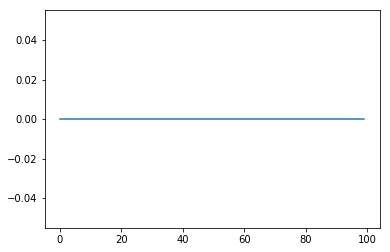

In [22]:
cost_history = []
sess = tf.Session(graph=g1)
tf.reset_default_graph()
sess.run(init)
for epoch in range(training_epochs):
    _, cost = sess.run([optimizer, loss], feed_dict={X: X_data, Y: y_data})
    cost_history.append(cost)
    
print('Last cost: ', round(cost_history[-1], 3))
plt.plot(cost_history)
saver.save(sess, "model_adam.ckpt")
sess.close()